# Experiment 1

In [24]:
import pathlib

import pandas as pd
import numpy as np
import pickle
from scipy import stats
import seaborn as sns

from videoannotator import config as cfg, experiments, data

In [2]:
sns.set_context('notebook')

## helpers

In [3]:
@dataclass(frozen=True)
class Beat:
    champ: experiments.Metric
    chall: experiments.Metric
        
    @property
    def better(self):
        if self.champ is None:
            return True
        return self.chall.mean > self.champ.mean
    
    @property
    def sig(self):
        if self.better:
            if self.champ is None: return True
            return (self.chall.mean - self.chall.std) > (self.champ.mean + self.champ.std)
        return False
    
    @property
    def lift(self):
        if self.champ and self.chall:
            return self.chall.mean / self.champ.mean - 1
        
    @property
    def gain(self):
        if self.champ and self.chall:
            return self.chall.mean - self.champ.mean
    
    def __repr__(self):
        return f"Beat(better={self.better}, sig={self.sig})"

def at(l, cnt):
    d = res[l]
    cmp = {
        method: er
        for (n, method, scoring), er in d['cmp'].items()
        if n == cnt and scoring == 'average_precision'
    }
    va = [
        x
        for x in d['checkpoints']
        if len(x.lds_train) <= (cnt + 10)  # allow for up to n + 10
    ]
    va_ap = max(va, key=lambda x: x.average_precision.mean).average_precision if len(va) > 0 else None
    return dict(
        label=l,
        baseline=d['baseline_agg'],
        zs=d['zero_shot'].average_precision,
        va_cnt=len(va[-1].lds_train) if len(va) > 0 else None,
        va=va_ap,
        cmp_zs=cmp['zero-shot'].average_precision if 'zero-shot' in cmp else None,
        cmp_random=cmp['random'].average_precision if 'random' in cmp else None,
        cmp_comb=cmp['zero-shot-50-random-50'].average_precision if 'zero-shot-50-random-50' in cmp else None,
    )

def beat_cols(champ_, chall_):
    return [
        Beat(champ=champ, chall=chall)
        for champ, chall in zip(champ_, chall_)
    ]

def analyze(cnt):
    df = pd.DataFrame(map(lambda l: at(l, cnt=cnt), res.keys()))
    n = len(df)
    df = df[df.va_cnt.notnull()]
    if len(df) < n:
        print(f'lost {n - len(df)} / {n} for cnt= {cnt}')
    return df.assign(
        va_beats_bl=beat_cols(df.baseline, df.va),
        va_beats_zs=beat_cols(df.zs, df.va),
        va_beats_cmp_zs=beat_cols(df.cmp_zs, df.va),
        va_beats_cmp_rand=beat_cols(df.cmp_random, df.va),
        va_beats_cmp_comb=beat_cols(df.cmp_comb, df.va),
        cnt=cnt,
    )

def agg(df, sig):
    df = df.groupby('cnt').apply(
        lambda rows: pd.Series(dict(
            beats_baseline=rows.va_beats_bl.apply(lambda x: x.better).mean(),
            beats_baseline_sig=rows.va_beats_bl.apply(lambda x: x.sig).mean(),
            beats_zs=rows.va_beats_zs.apply(lambda x: x.better).mean(),
            beats_zs_sig=rows.va_beats_zs.apply(lambda x: x.sig).mean(),
            beats_cmp_rand=rows.va_beats_cmp_rand.apply(lambda x: x.better).mean(),
            beats_cmp_rand_sig=rows.va_beats_cmp_rand.apply(lambda x: x.sig).mean(),
            beats_cmp_zs=rows.va_beats_cmp_zs.apply(lambda x: x.better).mean(),
            beats_cmp_zs_sig=rows.va_beats_cmp_zs.apply(lambda x: x.sig).mean(),
            beats_cmp_comb=rows.va_beats_cmp_comb.apply(lambda x: x.better).mean(),
            beats_cmp_comb_sig=rows.va_beats_cmp_comb.apply(lambda x: x.sig).mean(),
        ))
    )
    cols = [c for c in df.columns if ((sig and '_sig' in c) or (not sig and '_sig' not in c))]
    return df[cols]


def _get_diff(df, c):
    return [
        x.chall.mean - x.champ.mean
        for x in df[c]
        if x.lift
    ]

def f(df, col=None):
    rows = []

    cols = [c for c in d.columns if 'va_beats_' in c]
    cs = cols if col is None else [col]
    for c in cs:
        gain = _get_diff(df, c)
        if len(gain) == 0:
            x = 'nan'
            continue
        x = np.percentile(gain, q=50)
        rows.append(dict(c=c, val=x))

    if col is None:
        return pd.DataFrame(rows).set_index('c')
    else:
        return pd.Series([x['val'] for x in rows], index=[x['c'] for x in rows])
    
def coverage(df):
    cs = ['va_beats_cmp_zs', 'va_beats_cmp_rand', 'va_beats_cmp_comb']
    return pd.Series([
        sum(
            x.champ is not None
            for x in df[c]
        ) / len(cfg.LABELS)
        for c in cs
    ], index=cs)


def lift(df, q, col=None):
    cs = [c for c in cols if 'bl' not in c] if col is None else [col]
    return pd.Series([
        np.percentile(_get_diff(df, c), q=q)
        for c in cs
    ], index=cs)

def plot(res, label):
    try:
        pd.DataFrame(
            dict(
                n=n,
                method=method,
                r=r.average_precision.mean,
            )
            for (n, method, scoring), r in res[label]['cmp'].items()
            if scoring == 'average_precision'
        ).pivot_table(index='n', columns='method', values='r').plot()
    except Exception as e:
        print(f'failed {label} error: {e}')
    pd.DataFrame(
        dict(n=len(er.lds_train), ap=er.average_precision.mean)
        for er in res[label]['checkpoints']
    ).set_index('n').ap.plot()
    plt.hlines(
        res[label]['baseline_agg'].mean,
        xmin=0,
        xmax=1000,
        colors='r',
        linestyles='dotted',
    )
    plt.hlines(
        res[label]['zero_shot'].average_precision.mean,
        xmin=0,
        xmax=1000,
        colors='k',
        linestyles='dotted',
    )
    plt.ylim([0, 1])
    plt.title(label)
    plt.show()

## run experiment 1

In [4]:
exp = experiments.Experiment()

In [5]:
group_lookup = {
    v: k
    for k, vs in cfg.LABEL_GROUPS.items()
    for v in vs
}

In [6]:
# number of labels
len(group_lookup)

56

In [26]:
# this takes ~20 mins on a machine with 64 CPUs and 64GB RAM
path_results_pkl = 'exp1_results.pkl'
if not pathlib.Path(path_results_pkl).exists():
    res = exp.experiment_active_learning_batch(labels=cfg.LABELS)
    pickle.dump(res, open(path_results_pkl, 'wb'))
else:
    res = pickle.load(open(path_results_pkl, 'rb'))

In [ ]:
# organize the data for analysis
df = pd.concat([analyze(n) for n in (25, 50, 100, 500, 1000)])
d = df.assign(group=df.label.map(group_lookup))

## Fig 7

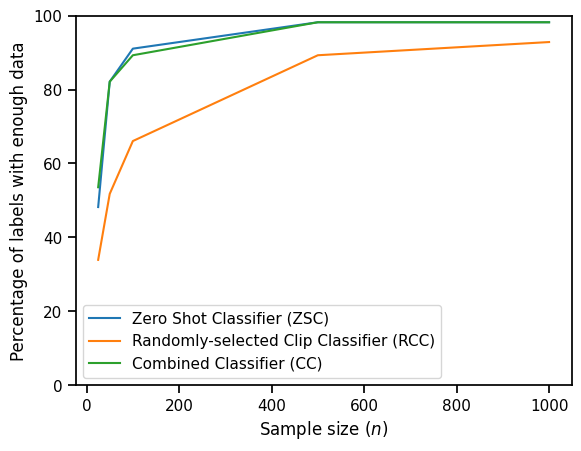

In [28]:
cov = d.groupby('cnt').apply(coverage) * 100
cov.rename(columns=dict(
    va_beats_cmp_zs='Zero Shot Classifier (ZSC)',
    va_beats_cmp_rand='Randomly-selected Clip Classifier (RCC)',
    va_beats_cmp_comb='Combined Classifier (CC)',
)).plot()
plt.xlabel('Sample size ($n$)')
_ = plt.ylabel('Percentage of labels with enough data')
_ = plt.ylim([0, 100])

## Fig 8

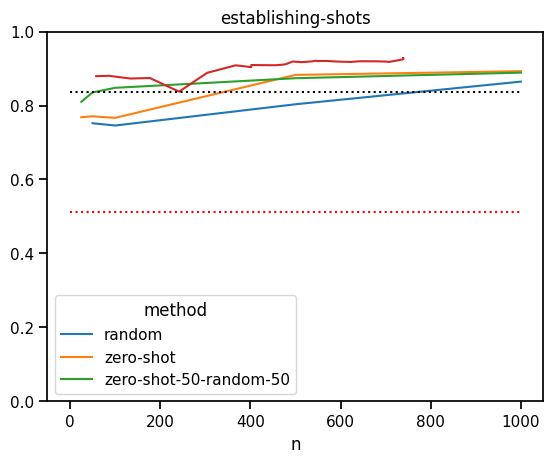

In [29]:
label = 'establishing-shots'
plot(res, label)

## Fig 9

WARNING 2024-02-09 04:42:18,875 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:18,942 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2024-02-09 04:42:18,950 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 04:42:18,962 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:18,962 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 04:42:19,117 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2024-02-09 04:42:19,125 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 04:42:19,141 experiments.py(32) Metric 

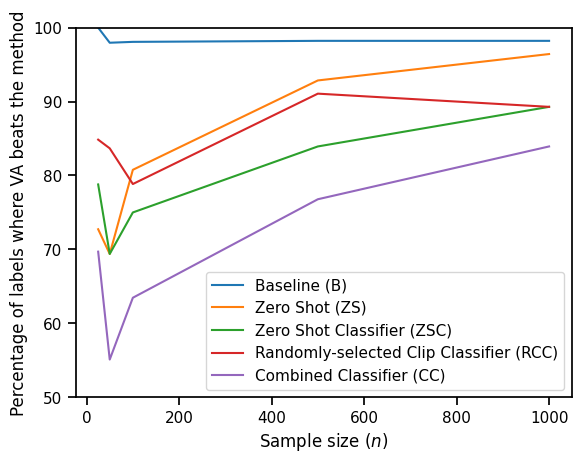

In [30]:
q = (df.groupby('cnt').apply(lambda xs: pd.Series({
    c: sum(
        (x.lift and x.lift >= 0) or (x.chall is not None and x.champ is None)
        for x in xs[c]
    ) / sum(
        x.chall is not None
        for x in xs[c]
    )
    for c in df.columns if '_beats_' in c
})) * 100)
q.rename(columns={
    'va_beats_bl': 'Baseline (B)',
    'va_beats_zs': 'Zero Shot (ZS)',
    'va_beats_cmp_zs': 'Zero Shot Classifier (ZSC)',
    'va_beats_cmp_rand': 'Randomly-selected Clip Classifier (RCC)',
    'va_beats_cmp_comb': 'Combined Classifier (CC)',
}).plot()
plt.ylim([50, 100])
plt.xlabel('Sample size ($n$)')
_ = plt.ylabel('Percentage of labels where VA beats the method')

## Table 2

In [31]:
(d[d.cnt != 500].groupby(['cnt', 'group']).apply(lambda x: f(x, col='va_beats_cmp_comb')).unstack().T * 100).round(1).droplevel(0) #.to_latex()

WARNING 2024-02-09 04:42:22,168 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:22,168 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


cnt,25,50,100,1000
group,,,,
emotions,-6.0,-5.1,-4.2,3.7
events_actions,6.9,5.5,5.7,3.8
focus,1.2,-1.2,-0.4,1.8
genres,6.6,5.3,3.9,1.8
motion,31.5,1.2,5.6,3.0
sensitivities,0.5,-0.3,0.8,3.4
shot_types,1.2,0.6,0.5,2.3
time_location,4.6,-8.5,1.3,1.4


In [32]:
# last row in table 2
(d.groupby(['cnt']).apply(lambda x: f(x, col='va_beats_cmp_comb')).unstack().T * 100).round(1)

WARNING 2024-02-09 04:42:23,843 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:23,844 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 04:42:23,851 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


                   cnt 
va_beats_cmp_comb  25      1.2
                   50      0.4
                   100     1.5
                   500     1.7
                   1000    2.9
dtype: float64

## store values needed for experiment 2

### store last and best values per label

In [33]:
ap_va_best = {
    l: dict(
        last=res[l]['checkpoints'][-1].average_precision.mean,
        best=max(
            res[l]['checkpoints'],
            key=lambda x: (
                x.average_precision.mean
                if x.average_precision.mean is not None
                else -1
            ),
        ).average_precision.mean
    )
    for l in cfg.LABELS
}
# this object is used for experiment 2
pickle.dump(ap_va_best, open('ap_va_best.pkl', 'wb'))

WARNING 2024-02-09 04:42:29,604 experiments.py(32) Metric has NaN values: (0.2, nan, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333)
WARNING 2024-02-09 04:42:29,605 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:29,606 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:29,606 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:29,607 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:29,607 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 04:42:29,608 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 04:42:29,608 experiments.py(32) Metric has NaN values:

### per-label AP gain at n=1,000
for labels with max(n) < 1000, we just take the last value

In [34]:
d1000 = d[d.cnt == 1_000]
q = d1000[['label']].assign(gain=d[d.cnt == 1000]['va_beats_cmp_comb'].apply(lambda x: x.gain)).set_index('label').gain.to_dict()
pickle.dump(q, open('exp1_gain.pkl', 'wb'))

WARNING 2024-02-09 04:42:31,444 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 04:42:31,444 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
